In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


In [22]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [27]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=-1,
                startWithBatchNormalized=False,optimizer="Adam"):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))        
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, number_of_features))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [19]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=-1,
                         startWithBatchNormalized=False,optimizer="Adam"):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))


In [24]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [25]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 1
dense_layer[0]; unit:512
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 1,916,420
Trainable params: 1,916,420
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0

Epoch 00025: early stopping


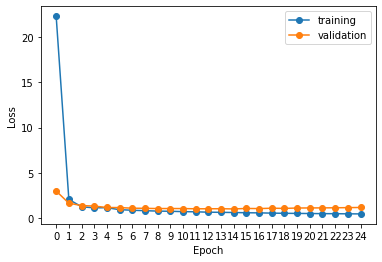

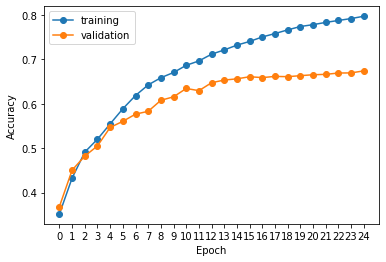

251/251 [==============================] - 2s 6ms/step - loss: 1.1588 - accuracy: 0.6875 - precision: 0.7608 - recall: 0.6241

Test Acc. 68.75%
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1978
           1       0.74      0.68      0.71      1957
           2       0.86      0.69      0.77      2069
           3       0.55      0.74      0.63      2011

   micro avg       0.69      0.69      0.69      8015
   macro avg       0.71      0.69      0.69      8015
weighted avg       0.71      0.69      0.69      8015
 samples avg       0.69      0.69      0.69      8015



In [6]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512]
                    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               131328    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 2,046,724
Trainable params: 

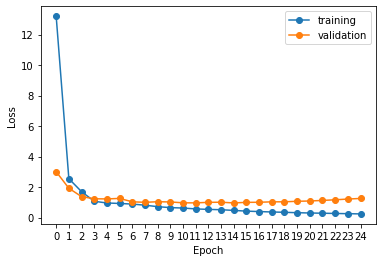

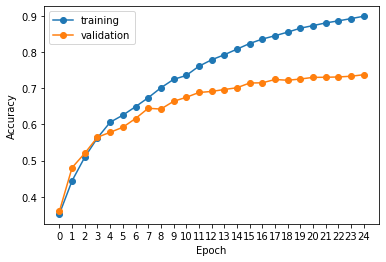

251/251 [==============================] - 2s 6ms/step - loss: 1.2255 - accuracy: 0.7493 - precision: 0.7839 - recall: 0.7125

Test Acc. 74.93%
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1978
           1       0.76      0.77      0.76      1957
           2       0.81      0.80      0.81      2069
           3       0.73      0.69      0.71      2011

   micro avg       0.75      0.75      0.75      8015
   macro avg       0.75      0.75      0.75      8015
weighted avg       0.75      0.75      0.75      8015
 samples avg       0.75      0.75      0.75      8015



In [8]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256]
                    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
__________________

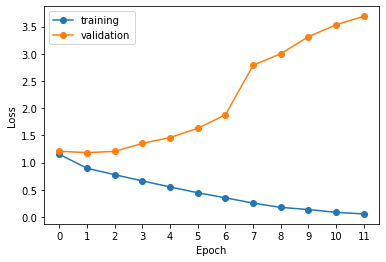

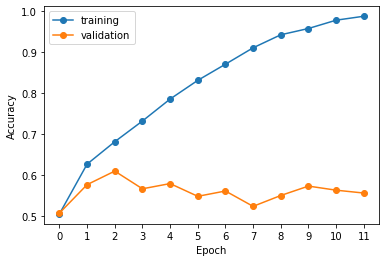

251/251 [==============================] - 2s 6ms/step - loss: 5.6787 - accuracy: 0.5604 - precision: 0.5824 - recall: 0.5298

Test Acc. 56.04%
              precision    recall  f1-score   support

           0       0.83      0.34      0.49      1978
           1       0.81      0.42      0.55      1957
           2       0.84      0.54      0.66      2069
           3       0.39      0.93      0.54      2011

   micro avg       0.56      0.56      0.56      8015
   macro avg       0.72      0.56      0.56      8015
weighted avg       0.72      0.56      0.56      8015
 samples avg       0.56      0.56      0.56      8015



In [13]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256],
                     isBatchNormalized=True
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:1024
dense_layer[1]; unit:512
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 1024)              3828736   
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               524800    
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 4,

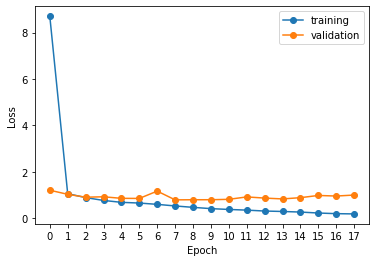

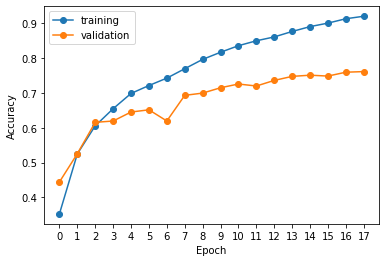

251/251 [==============================] - 2s 6ms/step - loss: 0.9227 - accuracy: 0.7722 - precision: 0.8042 - recall: 0.7466

Test Acc. 77.22%
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      1978
           1       0.76      0.82      0.79      1957
           2       0.84      0.81      0.82      2069
           3       0.68      0.79      0.73      2011

   micro avg       0.77      0.77      0.77      8015
   macro avg       0.78      0.77      0.77      8015
weighted avg       0.78      0.77      0.77      8015
 samples avg       0.77      0.77      0.77      8015



In [6]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,512]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:2048
dense_layer[1]; unit:1024
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 2048)              7657472   
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              2098176   
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 9

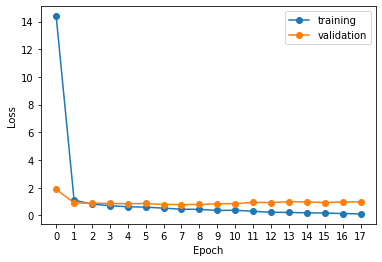

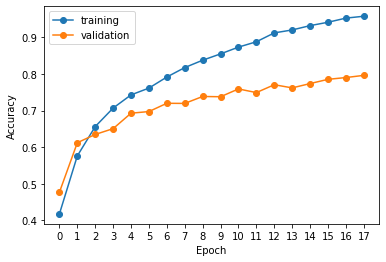

251/251 [==============================] - 2s 6ms/step - loss: 1.0454 - accuracy: 0.7915 - precision: 0.8081 - recall: 0.7792

Test Acc. 79.15%
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1978
           1       0.75      0.85      0.80      1957
           2       0.87      0.80      0.83      2069
           3       0.77      0.76      0.77      2011

   micro avg       0.79      0.79      0.79      8015
   macro avg       0.79      0.79      0.79      8015
weighted avg       0.79      0.79      0.79      8015
 samples avg       0.79      0.79      0.79      8015



In [7]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[2048,1024]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:2048
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              8390656   
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 2

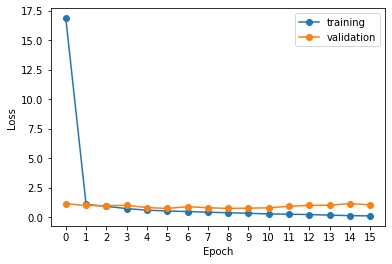

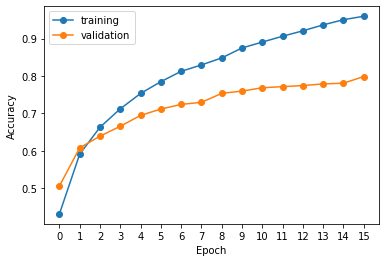

251/251 [==============================] - 2s 6ms/step - loss: 1.0362 - accuracy: 0.8040 - precision: 0.8147 - recall: 0.7964

Test Acc. 80.40%
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1978
           1       0.80      0.80      0.80      1957
           2       0.84      0.86      0.85      2069
           3       0.76      0.80      0.78      2011

   micro avg       0.80      0.80      0.80      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.80      0.80      0.80      8015
 samples avg       0.80      0.80      0.80      8015



In [9]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 3
dense_layer[0]; unit:4096
dense_layer[1]; unit:2048
dense_layer[2]; unit:1024
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              8390656   
_________________________________________________________________
fc_2 (Dense)                 (None, 1024)              2098176   
_________________________________________________________________
dense (Dense)                (None, 4)                 

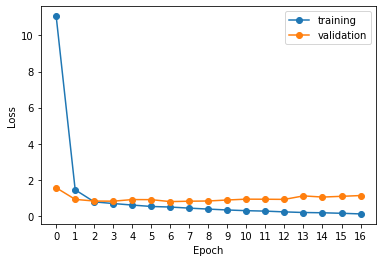

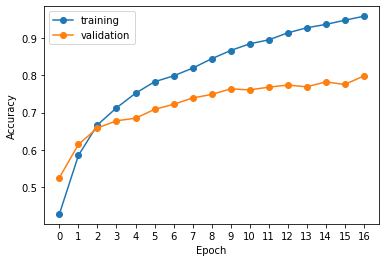

251/251 [==============================] - 2s 6ms/step - loss: 1.1643 - accuracy: 0.7999 - precision: 0.8125 - recall: 0.7879

Test Acc. 79.99%
              precision    recall  f1-score   support

           0       0.82      0.76      0.78      1978
           1       0.77      0.84      0.81      1957
           2       0.88      0.80      0.84      2069
           3       0.74      0.81      0.77      2011

   micro avg       0.80      0.80      0.80      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.80      0.80      0.80      8015
 samples avg       0.80      0.80      0.80      8015



In [10]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048,1024]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:2048
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0      

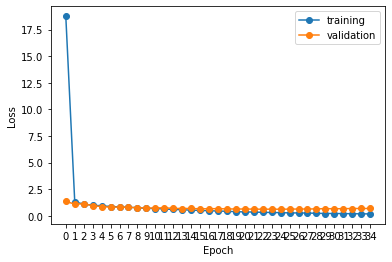

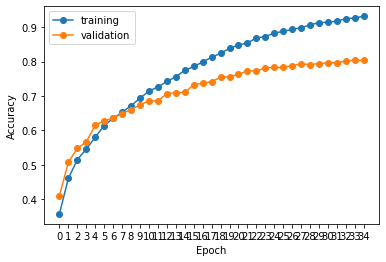

251/251 [==============================] - 2s 6ms/step - loss: 0.6564 - accuracy: 0.8072 - precision: 0.8399 - recall: 0.7792

Test Acc. 80.72%
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1978
           1       0.83      0.80      0.81      1957
           2       0.84      0.85      0.85      2069
           3       0.77      0.78      0.77      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [12]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:3072
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 3072)              12585984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3072)              0      

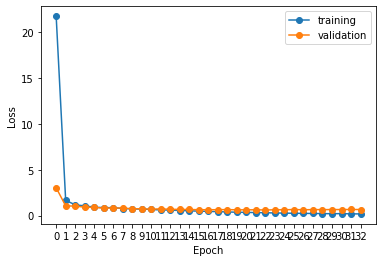

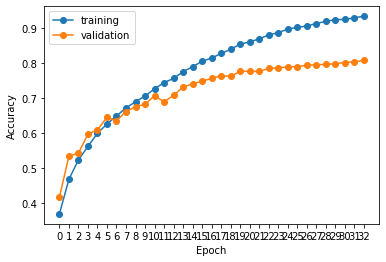

251/251 [==============================] - 2s 6ms/step - loss: 0.6616 - accuracy: 0.8107 - precision: 0.8425 - recall: 0.7844

Test Acc. 81.07%
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1978
           1       0.83      0.80      0.81      1957
           2       0.87      0.85      0.86      2069
           3       0.76      0.79      0.77      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [13]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,3072], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:4096
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0      

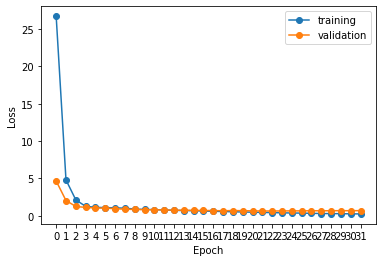

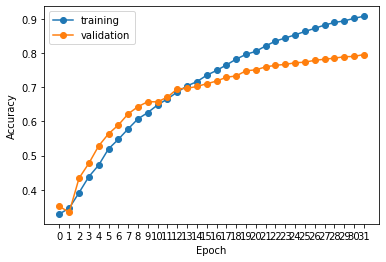

251/251 [==============================] - 2s 6ms/step - loss: 0.7085 - accuracy: 0.7949 - precision: 0.8278 - recall: 0.7609

Test Acc. 79.49%
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1978
           1       0.79      0.80      0.80      1957
           2       0.87      0.83      0.85      2069
           3       0.75      0.79      0.77      2011

   micro avg       0.79      0.79      0.79      8015
   macro avg       0.80      0.79      0.79      8015
weighted avg       0.80      0.79      0.80      8015
 samples avg       0.79      0.79      0.79      8015



In [14]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,4096], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:5120
dense_layer[1]; unit:4096
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 5120)              19143680  
_________________________________________________________________
dropout (Dropout)            (None, 5120)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 4096)              20975616  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0      

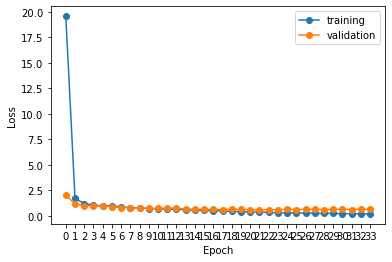

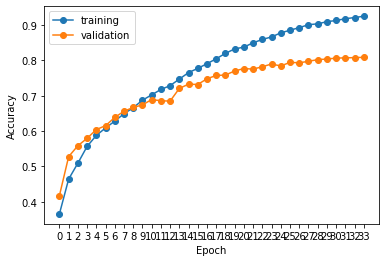

251/251 [==============================] - 2s 6ms/step - loss: 0.6373 - accuracy: 0.8125 - precision: 0.8476 - recall: 0.7798

Test Acc. 81.25%
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1978
           1       0.80      0.83      0.81      1957
           2       0.88      0.84      0.86      2069
           3       0.78      0.80      0.79      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [15]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[5120,4096], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:6144
dense_layer[1]; unit:5120
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 6144)              22972416  
_________________________________________________________________
dropout (Dropout)            (None, 6144)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 5120)              31462400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 5120)              0      

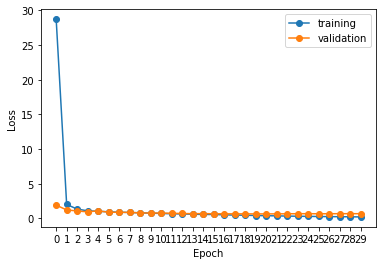

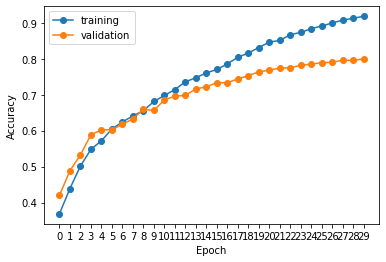

251/251 [==============================] - 2s 6ms/step - loss: 0.7056 - accuracy: 0.8054 - precision: 0.8379 - recall: 0.7750

Test Acc. 80.54%
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1978
           1       0.81      0.83      0.82      1957
           2       0.85      0.84      0.85      2069
           3       0.78      0.77      0.77      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.80      0.81      0.80      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [16]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[6144,5120], dropOutRate=0.2
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:6144
dense_layer[1]; unit:5120
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 6144)              22972416  
_________________________________________________________________
dropout (Dropout)            (None, 6144)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 5120)              31462400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 5120)              0      

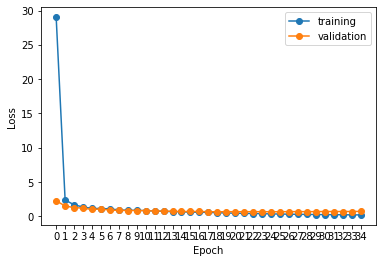

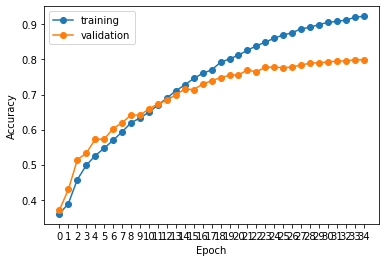

251/251 [==============================] - 2s 5ms/step - loss: 0.7417 - accuracy: 0.7986 - precision: 0.8263 - recall: 0.7691

Test Acc. 79.86%
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1978
           1       0.81      0.80      0.81      1957
           2       0.85      0.85      0.85      2069
           3       0.77      0.77      0.77      2011

   micro avg       0.80      0.80      0.80      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.80      0.80      0.80      8015
 samples avg       0.80      0.80      0.80      8015



In [20]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[6144,5120], dropOutRate=0.2
                    )

In [26]:
# Do hyperparam tuning

number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array_size = hp.Int('dense_layers_unit_array_size', 
                                          min_value=1, max_value=4, step=1)
    dense_layers_unit_array = []
    for i in range(dense_layers_unit_array_size):
        dense_layers_unit_array.append(hp.Int('dense_layers_unit_' + str(i), 
                                       min_value=4096, max_value=10240, step=512))
    
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.01, 0.001, 0.002]),
                activation="relu", 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.5, step=0.1),
                startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),
                optimizer=hp.Choice("optimizer", values=["Adam", "SGD"])       
                       )
    
    return model
                        
                                           

INFO:tensorflow:Reloading Oracle from existing project ./eeg/oracle.json
number_of_features: 3738
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:4096
learningRate: 0.01
isBatchNormalized: 1 ; dropOutRate: 0.0
INFO:tensorflow:Reloading Tuner from ./eeg/tuner0.json
INFO:tensorflow:Oracle triggered exit
#### Hypertuning results:
dense_layers_unit_array_size: 3
dense_layers_unit_0: 7680
dense_layers_unit_1: 8704
dense_layers_unit_2: 9216
No dense_layers_unit_3
learningRate: 0.001
isBatchNormalized: 0
dropOutRate: 0.0
#########################################

number_of_features: 3738
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:7680
dense_layer[1]; unit:8704
d

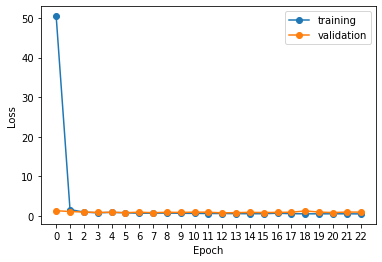

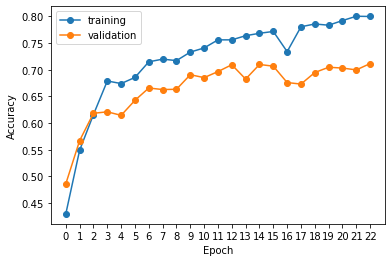

251/251 [==============================] - 2s 7ms/step - loss: 0.8780 - accuracy: 0.7216 - precision: 0.8422 - recall: 0.6485

Test Acc. 72.16%
              precision    recall  f1-score   support

           0       0.88      0.59      0.71      1978
           1       0.87      0.66      0.75      1957
           2       0.60      0.92      0.73      2069
           3       0.70      0.71      0.71      2011

   micro avg       0.72      0.72      0.72      8015
   macro avg       0.76      0.72      0.72      8015
weighted avg       0.76      0.72      0.72      8015
 samples avg       0.72      0.72      0.72      8015



In [35]:
tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='.',
#                      seed=1234,
                     project_name='eeg')

epochs = 40
epoch_denominator=10.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")
print("dense_layers_unit_array_size:",best_hps.get('dense_layers_unit_array_size'))


print("dense_layers_unit_0:",best_hps.get('dense_layers_unit_0'))

print("dense_layers_unit_1:",best_hps.get('dense_layers_unit_1'))

print("dense_layers_unit_2:",best_hps.get('dense_layers_unit_2'))
try:
    print("dense_layers_unit_3:",best_hps.get('dense_layers_unit_3'))
except:
    print("No dense_layers_unit_3")
print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))


epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:256
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 256)               957184    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
_________________________________________________________________
activation (Activation)    

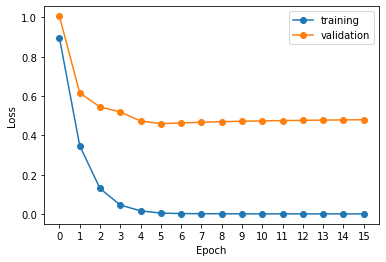

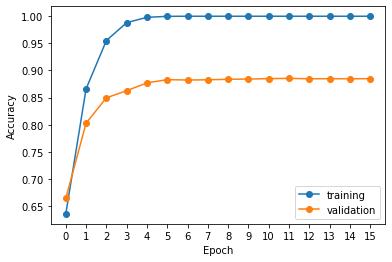

251/251 [==============================] - 2s 5ms/step - loss: 0.5395 - accuracy: 0.8799 - precision: 0.8843 - recall: 0.8761

Test Acc. 87.99%
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1978
           1       0.88      0.89      0.88      1957
           2       0.92      0.91      0.92      2069
           3       0.88      0.84      0.86      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [29]:
#Aris setup
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:256
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: tanh
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 256)               957184    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
_________________________________________________________________
activation (Activation)    

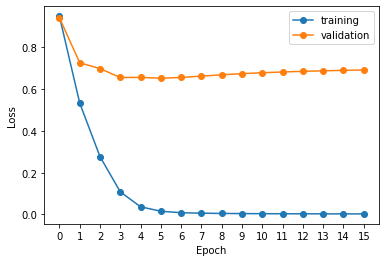

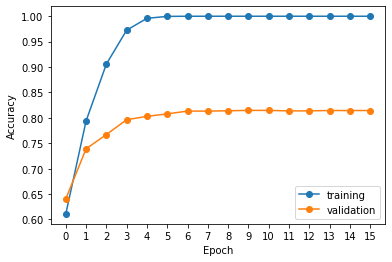

251/251 [==============================] - 2s 6ms/step - loss: 0.7119 - accuracy: 0.8102 - precision: 0.8161 - recall: 0.8051

Test Acc. 81.02%
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1978
           1       0.82      0.81      0.81      1957
           2       0.85      0.86      0.86      2069
           3       0.80      0.76      0.78      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [30]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="tanh"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:256
dense_layer[1]; unit:256
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 256)               957184    
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               65792     
_________________________________________________________________
de

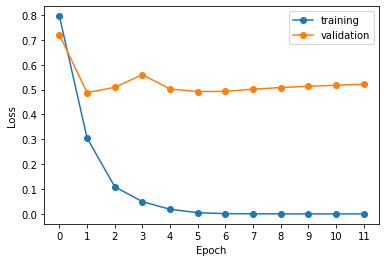

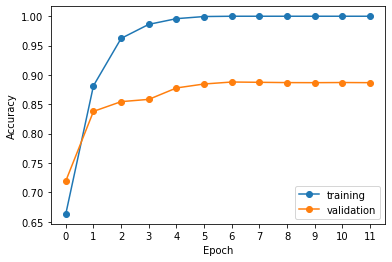

251/251 [==============================] - 2s 6ms/step - loss: 0.5573 - accuracy: 0.8830 - precision: 0.8848 - recall: 0.8802

Test Acc. 88.30%
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1978
           1       0.89      0.89      0.89      1957
           2       0.92      0.91      0.92      2069
           3       0.88      0.85      0.86      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [31]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:256
dense_layer[1]; unit:512
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 256)               957184    
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               131584    
_________________________________________________________________
de

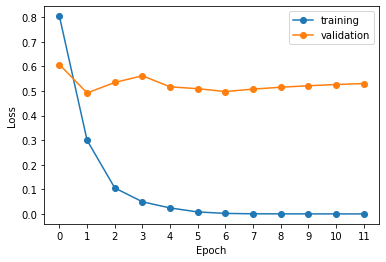

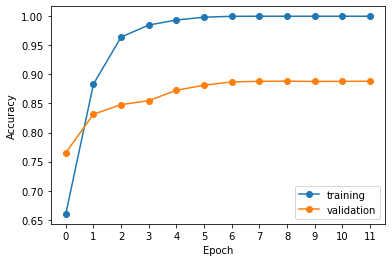

251/251 [==============================] - 2s 6ms/step - loss: 0.5932 - accuracy: 0.8838 - precision: 0.8865 - recall: 0.8818

Test Acc. 88.38%
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1978
           1       0.88      0.90      0.89      1957
           2       0.92      0.91      0.91      2069
           3       0.89      0.85      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [32]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:512
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               262656    
_________________________________________________________________
de

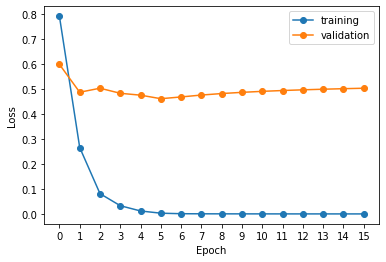

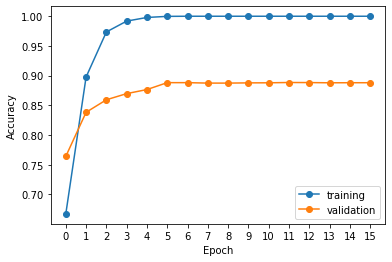

251/251 [==============================] - 2s 6ms/step - loss: 0.5551 - accuracy: 0.8867 - precision: 0.8898 - recall: 0.8848

Test Acc. 88.67%
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1978
           1       0.89      0.89      0.89      1957
           2       0.92      0.91      0.92      2069
           3       0.89      0.86      0.88      2011

   micro avg       0.89      0.89      0.89      8015
   macro avg       0.89      0.89      0.89      8015
weighted avg       0.89      0.89      0.89      8015
 samples avg       0.89      0.89      0.89      8015



In [33]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:1024
dense_layer[1]; unit:1024
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 1024)              3828736   
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              1049600   
_________________________________________________________________


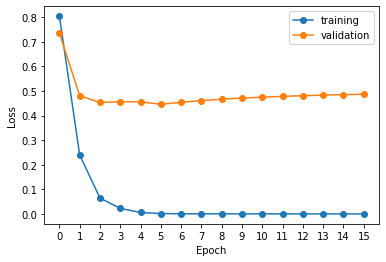

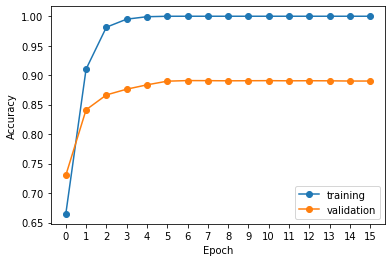

251/251 [==============================] - 2s 6ms/step - loss: 0.5342 - accuracy: 0.8830 - precision: 0.8849 - recall: 0.8811

Test Acc. 88.30%
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1978
           1       0.88      0.89      0.89      1957
           2       0.92      0.91      0.91      2069
           3       0.88      0.86      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [34]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,1024], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:2048
dense_layer[1]; unit:2048
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 2048)              7657472   
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              4196352   
_________________________________________________________________


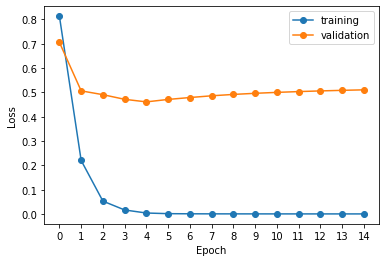

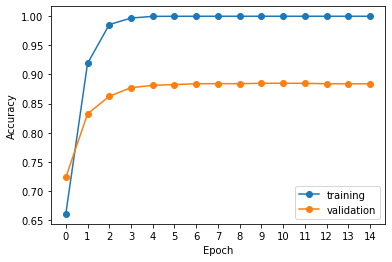

251/251 [==============================] - 2s 6ms/step - loss: 0.5188 - accuracy: 0.8831 - precision: 0.8871 - recall: 0.8813

Test Acc. 88.31%
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1978
           1       0.89      0.89      0.89      1957
           2       0.92      0.92      0.92      2069
           3       0.88      0.86      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [35]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[2048,2048], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 4
dense_layer[0]; unit:256
dense_layer[1]; unit:256
dense_layer[2]; unit:256
dense_layer[3]; unit:256
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 256)               957184    
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               65792     
__________________

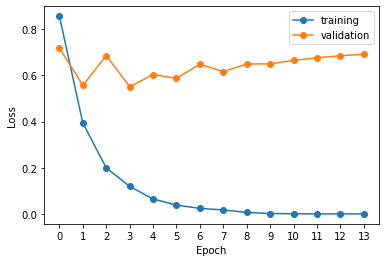

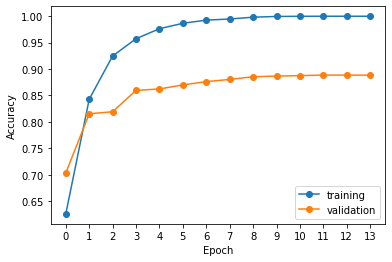

251/251 [==============================] - 2s 6ms/step - loss: 0.7325 - accuracy: 0.8846 - precision: 0.8870 - recall: 0.8842

Test Acc. 88.46%
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1978
           1       0.89      0.89      0.89      1957
           2       0.92      0.91      0.92      2069
           3       0.87      0.86      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [40]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,256,256,256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:256
dense_layer[1]; unit:896
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: -1
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 256)               957184    
_________________________________________________________________
fc_1 (Dense)                 (None, 896)               230272    
_________________________________________________________________
de

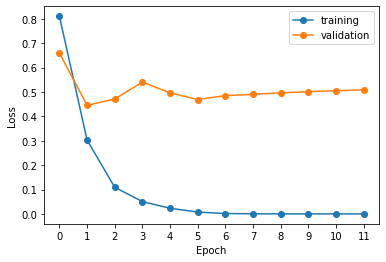

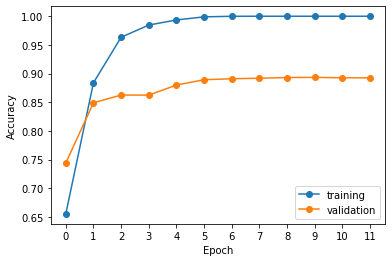

251/251 [==============================] - 2s 6ms/step - loss: 0.5716 - accuracy: 0.8832 - precision: 0.8860 - recall: 0.8815

Test Acc. 88.32%
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1978
           1       0.89      0.89      0.89      1957
           2       0.92      0.91      0.91      2069
           3       0.89      0.85      0.86      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015



In [42]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,896], learningRate=0.1, optimizer="SGD",
                     startWithBatchNormalized=True
                    )

In [43]:
# Do hyperparam tuning

number_of_features = X_train.shape[1]

def model_tuner2(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array_size = hp.Int('dl_unit_array_size', 
                                          min_value=1, max_value=4, step=1)
    dense_layers_unit_array = []
    
    dense_layers_units = hp.Int('dl_units', min_value=256, max_value=2048, step=128)
    for i in range(dense_layers_unit_array_size):
        dense_layers_unit_array.append(dense_layers_units)
    
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.05, 0.1, 0.2]),
                activation=hp.Choice('activation', values=["tanh", "relu"]), 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.5, step=0.1),
#                 startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),
                startWithBatchNormalized=True, #SGD needs this to be true to not crash in some combinations..       
#                 optimizer=hp.Choice("optimizer", values=["Adam", "SGD"])   
                optimizer="SGD"  #just limit to SGD since it seems it performs better than Adam in general        
                       )
    
    return model
                        
             

INFO:tensorflow:Reloading Oracle from existing project ./eeg/oracle.json
number_of_features: 3738
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:256
learningRate: 0.05
isBatchNormalized: 1 ; dropOutRate: 0.0
startWithBatchNormalized: True
optimizer: SGD ; activation: tanh
INFO:tensorflow:Reloading Tuner from ./eeg/tuner0.json
INFO:tensorflow:Oracle triggered exit
#### Hypertuning results:
dense_layers_unit_array_size: 1
dl_units: 512
learningRate: 0.2
isBatchNormalized: 0
dropOutRate: 0.5
#########################################

number_of_features: 3738
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
learningRate: 0.2
isBatchNormalized: 0 ; dropOutRate:

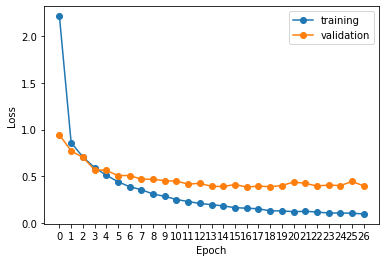

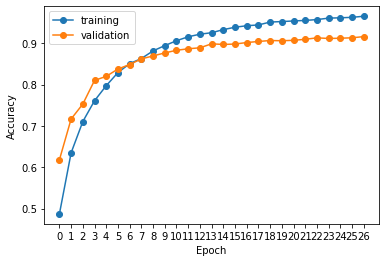

251/251 [==============================] - 1s 5ms/step - loss: 0.4517 - accuracy: 0.9135 - precision: 0.9230 - recall: 0.9069

Test Acc. 91.35%
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1978
           1       0.92      0.91      0.91      1957
           2       0.93      0.95      0.94      2069
           3       0.92      0.89      0.90      2011

   micro avg       0.91      0.91      0.91      8015
   macro avg       0.91      0.91      0.91      8015
weighted avg       0.91      0.91      0.91      8015
 samples avg       0.91      0.91      0.91      8015



In [46]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tuner = kt.Hyperband(model_tuner2,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')

epochs = 40

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")
print("dense_layers_unit_array_size:",best_hps.get('dl_unit_array_size'))

print("dl_units:",best_hps.get('dl_units'))
# try:
#     print("dense_layers_unit_0:",best_hps.get('dl_unit_0'))
# except:
#     print("No dense_layers_unit_0")
    
# try:
#     print("dense_layers_unit_1:",best_hps.get('dl_unit_1'))
# except:
#     print("No dense_layers_unit_1")
    
# try:
#     print("dense_layers_unit_2:",best_hps.get('dl_unit_2'))
# except:
#     print("No dense_layers_unit_2")

# try:
#     print("dense_layers_unit_3:",best_hps.get('dl_unit_3'))
# except:
#     print("No dense_layers_unit_3")
    
print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))
# print("startWithBatchNormalized:",best_hps.get('startWithBatchNormalized'))
# print("optimizer:",best_hps.get('optimizer'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))